## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.applications.resnet50 import ResNet50

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from utils import load_data, load_3d_data

def get_data(num_training=25709, num_validation=3000, num_pub_test=1000, num_pri_test=1000):
    """
    Load the dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = load_3d_data()
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_pub_test))
    X_pub_test = X_pub_test[mask]
    y_pub_test = y_pub_test[mask]
    mask = list(range(num_pri_test))
    X_pri_test = X_pri_test[mask]
    y_pri_test = y_pri_test[mask]

#     # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_pub_test -= mean_image
    X_pri_test -= mean_image  
    return X_train, y_train, X_val, y_val, X_pub_test, y_pub_test, X_pri_test, y_pri_test
    #return X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_pub_test, y_pub_test
   del X_pri_test, y_pri_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_pub_test, y_pub_test, X_pri_test, y_pri_test = get_data()
#X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = get_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Public test data shape: ', X_pub_test.shape)
print('Public test labels shape: ', y_pub_test.shape)
print('Private test data shape: ', X_pri_test.shape)
print('Private test labels shape: ', y_pri_test.shape)

Train data shape:  (25709, 48, 48, 3)
Train labels shape:  (25709,)
Validation data shape:  (3000, 48, 48, 3)
Validation labels shape:  (3000,)
Public test data shape:  (1000, 48, 48, 3)
Public test labels shape:  (1000,)
Private test data shape:  (1000, 48, 48, 3)
Private test labels shape:  (1000,)


In [3]:
X_train[999].shape

(48, 48, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


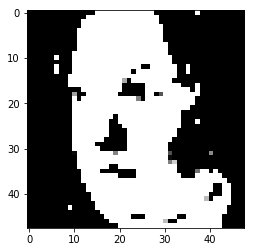

In [4]:
print(y_train[999])
plt.imshow(X_train[999]);

In [5]:
num_classes = 7

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_pub_test = keras.utils.to_categorical(y_pub_test, num_classes)
y_pri_test = keras.utils.to_categorical(y_pri_test, num_classes)

In [6]:
y_train[444]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [7]:
# As before, let's make everything float and scale
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_pub_test = X_pub_test.astype('float32')
X_pri_test = X_pri_test.astype('float32')
print(X_train.shape[1:])
X_train /= 255
X_val /= 255
X_pub_test /= 255
X_pri_test /= 255

(48, 48, 3)


In [8]:
# Please provide your solution here
# Create model_2 as mentioned in the exercise
# Let's build a CNN using Keras' Sequential capabilities
from keras.layers.normalization import BatchNormalization
from keras import models, layers
from keras.models import Model
from keras import regularizers
#Instantiate an empty model
base_model = ResNet50(include_top = False, weights = 'imagenet',
  input_tensor = None, input_shape = (48, 48, 3), pooling = 'None')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 7

x = Flatten()(base_model.output)
x = Dense(400, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

batch_size = 128

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\jstndlee\Anaconda3\envs\cecs551-project-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                 

In [9]:
rate = 3e-5

# initiate RMSprop optimizer
#opt = keras.optimizers.rmsprop(lr=rate, decay=1e-6)
opt = keras.optimizers.Adam(lr=rate, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

print('Learning rate: %f' % rate)
loss = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(X_val, y_val),
              shuffle=True,
              verbose=1)
score = model.evaluate(X_pri_test, y_pri_test, verbose=0)

Learning rate: 0.000030
Instructions for updating:
Use tf.cast instead.
Train on 25709 samples, validate on 3000 samples
Epoch 1/30
25709/25709 [==============================] - 21s 833us/step - loss: 2.5210 - acc: 0.1578 - val_loss: 1.9734 - val_acc: 0.1653
Epoch 2/30
25709/25709 [==============================] - 15s 589us/step - loss: 2.3516 - acc: 0.1974 - val_loss: 1.9604 - val_acc: 0.1657
Epoch 3/30
25709/25709 [==============================] - 14s 561us/step - loss: 2.2390 - acc: 0.2252 - val_loss: 1.9332 - val_acc: 0.1700
Epoch 4/30
25709/25709 [==============================] - 15s 597us/step - loss: 2.1610 - acc: 0.2461 - val_loss: 1.9154 - val_acc: 0.2193
Epoch 5/30
25709/25709 [==============================] - 15s 599us/step - loss: 2.0971 - acc: 0.2633 - val_loss: 1.9071 - val_acc: 0.2463
Epoch 6/30
25709/25709 [==============================] - 14s 552us/step - loss: 2.0374 - acc: 0.2754 - val_loss: 1.9027 - val_acc: 0.2207
Epoch 7/30
25709/25709 [=====================

In [10]:
print('Learning rate:', rate)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Learning rate: 3e-05
Test loss: 1.8827222681045532
Test accuracy: 0.16


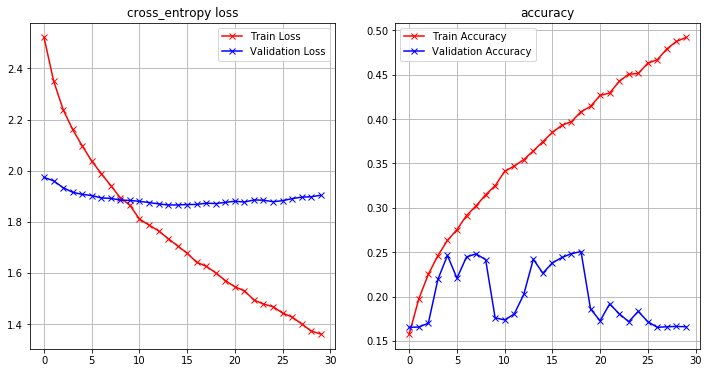

In [11]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    

plot_loss_accuracy(loss)

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

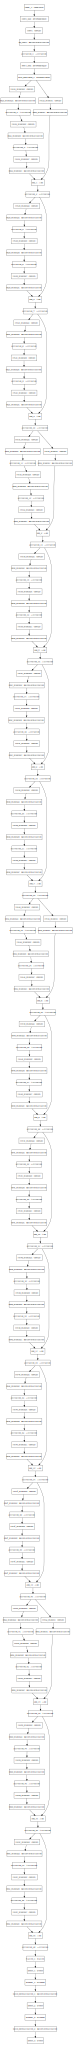

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))